# Overview 

In this notebook I will build a simple neural network and will apply two methods which may be useful for helping us undersand where the model is expected to fail: 
1. Clustering misclassifications with an unsupervised learning method to determine if there are any distinct clusters of images that the model is systematically misclassifying
2. Manually inspecting the images that were misclassified to determine whether such a method can be useful in grouping images based on some shared characteristic that confuses the neural netowrk

In [77]:
# import packages

import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.datasets import mnist
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras import regularizers
from keras import backend as K

# 1. Data Import and Preprocessing 

In [40]:

###Extract from file
with open("./data/processed_data/X.pkl","rb") as f:
    X = pickle.load(f)
    
###Extract from file
with open("./data/processed_data/y.pkl","rb") as f:
    y = pickle.load(f)
    
print(X.shape)
print(y.shape)

(25000, 66, 100)
(25000,)


## Train-test-split the data

After the modeling, I will be looking specifically at misclassifications to understand where the model is failing. In order to do this, I will need to visually inspect the actual images that are being misclassified. Therefore, when doing the train test split, I will include an **indices** list which will serve as an index for all of the images that I can later use to find the actual images corresponding to misclassifications. 

In [41]:
# create an index corresponding to individual images in the data
indeces = list(range(1,25001))
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(X, y,indeces, random_state=42, stratify = y)

In [42]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [43]:
print(X_train.shape)
print(y_train.shape)
print(len(indices_train))
print(X_test.shape)
print(y_test.shape)
print(len(indices_test))

(18750, 66, 100)
(18750,)
18750
(6250, 66, 100)
(6250,)
6250


## Check the class balance 

In [44]:
# checking class balance in train data

lst = []
for i in range(0, 5):
    count = list(y_train).count(i)
    lst.append((i, count))
lst

[(0, 3750), (1, 3750), (2, 3750), (3, 3750), (4, 3750)]

In [45]:
# checking class balanced in test data

lst = []
for i in range(0, 5):
    count = list(y_test).count(i)
    lst.append((i, count))
lst

[(0, 1250), (1, 1250), (2, 1250), (3, 1250), (4, 1250)]

## Reshape the data ro ingest it into keras 

In [46]:
# Reshape each image to be 28 x 28 x 1.
X_train = X_train.reshape(X_train.shape[0], 66, 100, 1)
X_test = X_test.reshape(X_test.shape[0], 66, 100, 1)

In [47]:
# Dummy the target variable 
y_train = np_utils.to_categorical(y_train, 5)
y_test = np_utils.to_categorical(y_test, 5)

In [48]:
y_test.shape

(6250, 5)

## Unrow the data and create a dataframe for sklearn

In [49]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(X_train_flat.shape)
print(y_train.shape)
print('')
print('')
print(X_test_flat.shape)
print(y_test.shape)

X_train_df = pd.DataFrame(X_train_flat)
X_test_df = pd.DataFrame(X_test_flat)
print('')
print('')
print('')

print(X_train_df.shape)
print(X_test_df.shape)

(18750, 6600)
(18750, 5)


(6250, 6600)
(6250, 5)



(18750, 6600)
(6250, 6600)


In [50]:
X_train_df.head()

0     1     2     3     4     5     6     7     8     9     ...  6590  \
0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   1.0   
1   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   1.0   
2   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   1.0   
3   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   1.0   
4   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   1.0   

   6591  6592  6593  6594  6595  6596  6597  6598  6599  
0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  
1   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  
2   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  
3   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  
4   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  

[5 rows x 6600 columns]

# 2. Baseline Model - Multinomial Logistic Regression 

I will use a multinomial logistic regression to run a one-vs-all multiclass classification on the data to get a baseline score. To run this model, we need the target variable in a single columns as opposed to dummy variables. 

In [52]:
# create a single column target variable 
y_train_col = np.argmax(y_train, axis=1)
y_test_col = np.argmax(y_test, axis=1)

In [56]:
# Create one-vs-rest logistic regression object
clf = LogisticRegression(random_state=0, multi_class='ovr', n_jobs = -1)

# Train model
model = clf.fit(X_train_df, y_train_col)

y_tr_pred_lr = clf.predict(X_train_df)
y_ts_pred_lr = clf.predict(X_test_df)

In [58]:
# get the accuracy scores
train_score = accuracy_score(y_tr_pred_lr, y_train_col)
test_score = accuracy_score(y_ts_pred_lr, y_test_col)

print(train_score)
print(test_score)

0.92352
0.78176


# 3. Modeling - Convolutional Neural Netowork 1

Let's build a relatively simple CNN with two convolutional layaers and 2 pooling layers. 

In [124]:
np.random.seed(42)

checkpointer = ModelCheckpoint(filepath="./best_weights.hdf5", 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=True)


cnn_model = Sequential()

cnn_model.add(Conv2D(filters = 6,
                    kernel_size = (6,6),
                    activation = 'relu', 
                    input_shape = (66, 100,1)
                    ))

cnn_model.add(MaxPooling2D(pool_size = (4,4)))

cnn_model.add(Conv2D(filters = 16,
                    kernel_size = (6,6),
                    activation = 'relu'
                    ))

cnn_model.add(MaxPooling2D(pool_size = (4,4)))

cnn_model.add(Flatten())

cnn_model.add(Dense(3000, activation = 'relu'))

cnn_model.add(Dense(3000, activation = 'relu'))

cnn_model.add(Dense(5, activation = 'softmax'))

cnn_model.compile(loss = 'categorical_crossentropy', 
                 optimizer = 'adam', 
                 metrics = ['accuracy'])

#early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


history = cnn_model.fit(X_train,
                        y_train,
                       batch_size = 4096, 
                       validation_data = (X_test, y_test),
                       epochs = 100,
                       callbacks=[checkpointer],
                       verbose = 1)

Train on 18750 samples, validate on 6250 samples
Epoch 1/100
18750/18750 [==============================] - 43s 2ms/step - loss: 1.6712 - acc: 0.2321 - val_loss: 1.6061 - val_acc: 0.2000

Epoch 00001: val_acc improved from -inf to 0.20000, saving model to ./best_weights.hdf5
Epoch 2/100
18750/18750 [==============================] - 43s 2ms/step - loss: 1.6016 - acc: 0.2251 - val_loss: 1.5910 - val_acc: 0.3581

Epoch 00002: val_acc improved from 0.20000 to 0.35808, saving model to ./best_weights.hdf5
Epoch 3/100
18750/18750 [==============================] - 42s 2ms/step - loss: 1.5726 - acc: 0.3517 - val_loss: 1.5163 - val_acc: 0.5333

Epoch 00003: val_acc improved from 0.35808 to 0.53328, saving model to ./best_weights.hdf5
Epoch 4/100
18750/18750 [==============================] - 41s 2ms/step - loss: 1.4598 - acc: 0.5094 - val_loss: 1.3497 - val_acc: 0.4120

Epoch 00004: val_acc did not improve from 0.53328
Epoch 5/100
18750/18750 [==============================] - 42s 2ms/step - l

18750/18750 [==============================] - 42s 2ms/step - loss: 0.3444 - acc: 0.8787 - val_loss: 0.3797 - val_acc: 0.8651

Epoch 00038: val_acc did not improve from 0.87184
Epoch 39/100
18750/18750 [==============================] - 43s 2ms/step - loss: 0.3385 - acc: 0.8826 - val_loss: 0.3750 - val_acc: 0.8686

Epoch 00039: val_acc did not improve from 0.87184
Epoch 40/100
18750/18750 [==============================] - 42s 2ms/step - loss: 0.3369 - acc: 0.8830 - val_loss: 0.3620 - val_acc: 0.8720

Epoch 00040: val_acc improved from 0.87184 to 0.87200, saving model to ./best_weights.hdf5
Epoch 41/100
18750/18750 [==============================] - 42s 2ms/step - loss: 0.3267 - acc: 0.8855 - val_loss: 0.3580 - val_acc: 0.8754

Epoch 00041: val_acc improved from 0.87200 to 0.87536, saving model to ./best_weights.hdf5
Epoch 42/100
18750/18750 [==============================] - 42s 2ms/step - loss: 0.3188 - acc: 0.8900 - val_loss: 0.3712 - val_acc: 0.8666

Epoch 00042: val_acc did not im


Epoch 00078: val_acc did not improve from 0.90016
Epoch 79/100
18750/18750 [==============================] - 41s 2ms/step - loss: 0.1993 - acc: 0.9325 - val_loss: 0.2868 - val_acc: 0.9035

Epoch 00079: val_acc improved from 0.90016 to 0.90352, saving model to ./best_weights.hdf5
Epoch 80/100
18750/18750 [==============================] - 42s 2ms/step - loss: 0.1997 - acc: 0.9316 - val_loss: 0.2933 - val_acc: 0.8987

Epoch 00080: val_acc did not improve from 0.90352
Epoch 81/100
18750/18750 [==============================] - 41s 2ms/step - loss: 0.1931 - acc: 0.9338 - val_loss: 0.2931 - val_acc: 0.8997

Epoch 00081: val_acc did not improve from 0.90352
Epoch 82/100
18750/18750 [==============================] - 42s 2ms/step - loss: 0.1938 - acc: 0.9340 - val_loss: 0.2901 - val_acc: 0.9021

Epoch 00082: val_acc did not improve from 0.90352
Epoch 83/100
18750/18750 [==============================] - 41s 2ms/step - loss: 0.1862 - acc: 0.9383 - val_loss: 0.2882 - val_acc: 0.9038

Epoch 00

This is what the model architecture looks like

In [98]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 61, 95, 6)         222       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 23, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 18, 16)        3472      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3000)              387000    
_________________________________________________________________
dense_2 (Dense)              (None, 3000)              9003000   
__________

In [89]:
# save model to JSON
model_json = cnn_model.to_json()
with open("./model/cnn_model_architecture.json", "w") as json_file:
    json_file.write(model_json)
# save weights to HDF5
cnn_model.save_weights("./model/cnn_model_weights.h5")
print("Saved model to disk")

Saved model to disk


### Evaluate the model 

In [99]:
# Evaluate model on test data.
score = cnn_model.evaluate(X_test,
                       y_test,
                       verbose=1)

labels = cnn_model.metrics_names

# Show model performance.
print(f'{labels[0]}: {score[0]}')
print(f'{labels[1]}: {score[1]}')

6250/6250 [==============================] - 7s 1ms/step
loss: 0.2716202089834213
acc: 0.9111999999618531


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


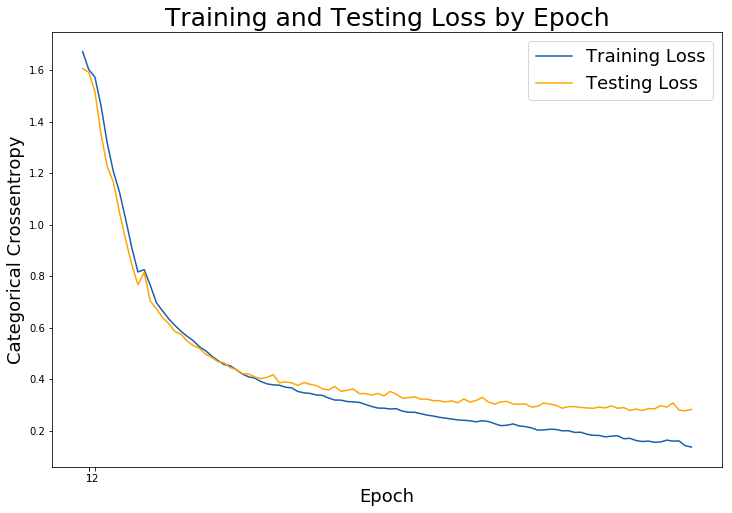

In [125]:
# plot the loss for training and testing sets over epochs 
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(list(np.linspace(1,2.1,3.1).astype(int)))

plt.legend(fontsize = 18);

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


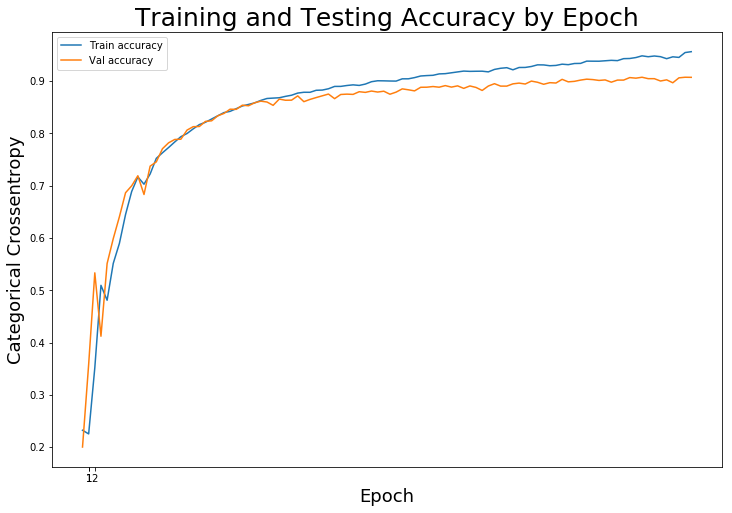

In [126]:
# Plot the accuracy for training and testing sets over ecpochs 
plt.figure(figsize=(12, 8))

plt.plot(history.history['acc'], label='Train accuracy')
plt.plot(history.history['val_acc'], label='Val accuracy')
plt.legend();

plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(list(np.linspace(1,2.1,3.1).astype(int)));

### Make predictions to build a confusion matrix 

In [127]:
y_tr_pred_cnn = cnn_model.predict_classes(X_train)
y_ts_pred_cnn = cnn_model.predict_classes(X_test)

y_test_col = np.argmax(y_test, axis=1)
y_train_col = np.argmax(y_train, axis=1)

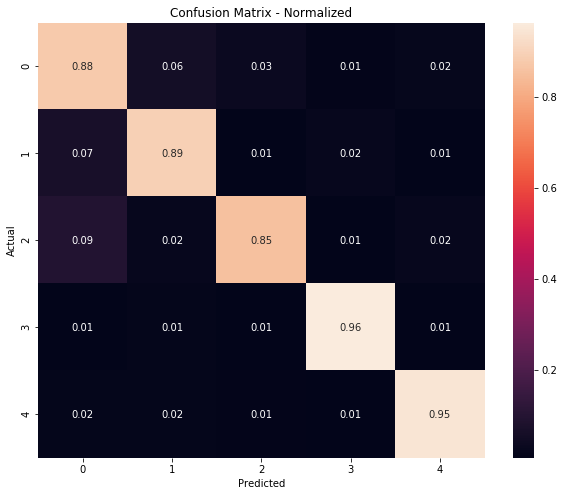

In [128]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10,8))

sns.heatmap(confusion_matrix(y_test_col, y_ts_pred_cnn).astype('float') / confusion_matrix(y_test_col, y_ts_pred_cnn).sum(axis=1)[:, np.newaxis],
           annot = True, fmt = '.2f', )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Normalized')
    
plt.show()



In [130]:
from sklearn.metrics import classification_report, accuracy_score
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4']
print(classification_report(y_test_col, y_ts_pred_cnn, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.82      0.88      0.85      1250
     class 1       0.89      0.89      0.89      1250
     class 2       0.93      0.85      0.89      1250
     class 3       0.95      0.96      0.96      1250
     class 4       0.94      0.95      0.95      1250

   micro avg       0.91      0.91      0.91      6250
   macro avg       0.91      0.91      0.91      6250
weighted avg       0.91      0.91      0.91      6250



# 4. Clustering Misclassifications 

It's interesting to look at the actual misclassificaitons produced by this model to determine whether there are any distinct patterns or features in the images that the model is misclassifying. Some questions this approach may help answer are: 
1. Can we cluster such images into groups? 
2. Do these clusters make sense? 
3. If yes, we can try and understand when the model is expected to fail at correctly predicting.
4. Is this failure within a reasonable acceptance criteria? 
5. If no – what can be done? 

I used unsupervised learning models to see if I could cluster misclassified images into meaningful groups. 
In order to acieve this, the indices_test variable created during the train_test_split of the data was filtered to align and correspond with the misclasifications to create a misclassifications datafame. 

In [138]:
predictions = pd.DataFrame({'index':indices_test, 
                            'y_test':list(y_test_col), 
                            'y_pred':list(y_ts_pred_cnn)})

In [139]:
mask = predictions['y_test']!=predictions['y_pred']
misclass = predictions[mask]
misclass.shape 

(579, 3)

In [140]:
misclass.head()

index  y_test  y_pred
9    8664       1       3
18  11005       2       0
27  18604       3       1
41   2473       0       4
51   7382       1       4

### Create a dataframe of all images that were misclassified 

In [146]:
X_test_df['index'] = indices_test

misclass_df = pd.concat([X_test_df, misclass], axis = 1, join_axes = [misclass['index']])

misclass_df.shape

The dataframe above is a dataframe containing the data for all images that were misclassified along with their true y values and their predictied y values. 

### Methods and the Results of Clustering 

DBScan clustering was first applied to the data which return no meaningful results as the only cluster produced was the noise with cluster label -1. 
<br/>
K-Means clustering was then applied with an arbitrary choice of 2 centroids as this was the simplest to work with. Later more than 2 centroids were chosen but did not lead to any meaningful results. 
<be/> 
One of the two clusters from K-means contained a total of only 4 images in it so these images were visually inspected with the following results: 
![clustered_images](../images/clustered_images.png)

The group of images in this cluster show no meaningful pattern therefore the results of clustering were deemed not useful. Another approach was taken to try and make sense of the misclassficiations. This approach was a manual visual inspection of the misclassified images. 

### What to do differently

We might consider clustering not the raw images themselves, but the image outputs from the hidden layers of the neural network. This is because the model might be misclassifying not based on some inherent distinct characteristic of the images themselves, but rather on the way it interprets/misinterprets some features once the image gets processed inside the nueral network. 

# 5. Manual Visual Inspection of Some Misclassified Images 

This dataframe **misclass** can bhelp  find the original images numbered the same as the **indices** variable which was later train_test_split along with X and y. Also the dataframe can help determine what the misclassification was by comparing the **y_test** and **y_pred** column values for that image. 

Looking back at the confusion matrix, I became specifically interested in looking at images that were cat doodles but were misclassified as airplanes especially because the doodles of these categories seem to be very distinct in their shape.But first let's look at a few examples of cat doodles that were correctly classified as cats (true positives):

### True Positive Cat Doodles

![tps](../images/tp_cats.png)

The six individual doodles above were randomly selected from a set of correctly classified cat images. There are noticably two distinct groups of cats that the neural network is correctly recognizing as cats: cat faces (the group of doodles on the left) and cats with their full bodies (the group of doodles on the right). While these are not the only groups of images the model is correctly classifying, these groups however come up most frequently among the true positive cat images. 

Now let's look at some cat doodles that were misclassified as airplanes and see whether there is any distinct characteristic about these images that sets them apart from the rest.

### Cats misclassified as airplanes

![cats_misclassified_as_airplanes](../images/cats_misclass_airplanes.png)

The above 11 doodles were also randomly selected from a set of cat images which the model incorrectly classified as airplanes. There are two distinct groups of doodle types here as well: cat faces that seem to have a smiley face (the group of images on the left) and cats that have no eyes on their faces (the group of doodles on the right). While these are not the only apparently identifiable groups of cat doodles that were misclassified as airplanes, the two groups presented here are the ones that occur most frequently among such misclassifications. 

But a question arises: what does a typical airplane doodle look like? And can we understand or intuit why the model has misclassified these cats as airplanes? Perhaps if we look at such a typtical airplane we can understand what features on that airplane the model is confusing with corresponding features on these cat doodles.

So then, these are some typical airplane doodles: 
![airplanes](../images/airplanes.png)

While there is some variation from doodle to doole, they all however share two distinct characteristics that are apparent to the humand eye: the body of the airplane and a pair of wings. 

If we were to compare the misclassified cat images to these airplane images, there is really no apparent reaso for why the model is recognizing these misclassified cats as airplanes. Airplane doodles look very different from cat doodles, at least according to my human perception! Let's look at some doodles of trees that were misclassified as airplanes:

![trees_misclassified_as_airplanes](../images/trees_misclass_airplanes.png)

Again, just by looking at these doodles as a human, It is not clear as to why the model misclassified them as airplanes. 

### The naive assumption of human-like machine perception


But perhaps the assumption that I've made here is naive: that the model will learn to recognize and differentiate visual information like a human does. Actually, it's a well known fact that a machine does not necessarily learn to process information as a human does... we know that it is capable of producing correct results, but how it does it is for the most part unknown - especially with neural netoworks that are very complex and contain many hidden layers. This is commonly what we refere to as the **black box** model: Input goes in, outcput comes out (often correct/good quality output) but we don't know what exactly happened in between input and output. 

### The slippery slope of thie approach of visually inspecting misclassifications

It's hard to tell whether manual visual inspection of misclassified iimages will lead to any meaningful results. It's even harder to determine whether meaningful results (as they may appear to us to be meaningful) are actually correct and not just a result of our own confirmation biases. As researchers, we always hope that we approach the problem free of bias - that we have taken measures to circumvent the tainting of results with our biases. But with problems such as this one we're dealing with here, it's even more difficult to ensure this because there is no clear goal we want to achieve, no expected results we want to see, but merely a blind deep dive into what these misclassifications can tell us and when they do tell us something, it's easy to get lost in chasing what we want this telling to be rather than what it actually is. 

This is not to say that this approach should not be taken at all, but only that it should be taken with great caution. 

### So what is the value of this approach then?

While the overall doodles of both cats and trees which were misclassified as airplanes did not show any apparent characteristics for why the misclassifications took place, there was something interesting in the results still which may help shed some light into why the model is misclassifying such doodles as we step further into the methods discussed in notebook **3.2. Modeling - An Improved Model and Looking Inside the Hidden Layers**. 
<br/>
What's interesting and is worhtile to investigate further is the emerged two groups of cat doodles among cat misclassifications: the cat faces that had smiley faces and the cat faces that had no eyes as discussed above. While this may be purely a coninicdence, I can't help but take a note of this and ask why or what is it about these groups of cat doodles that the model is mis-recognizing? Why does the model think they are airplanes and not alarm clocks for example?

Because the number of misclassifications is not incredibly large (~600), this pattern of misclassified cat doodles certainly is convincing enough to put the effort into looking at every single misclassification and perhaps manually classifying them into different groups as a human - something I tried to do with the clusterinig algorithm which didn't work. This is definitely something I plan to do in the future but not to come up with any conclusions about why the model is misclassifying such doodles, but only to use it as an informative piece of data going futher into inspecting the model's inner workings by visualizing its hidden layer ouptuts. Check out noebtook **3.2. Modeling - An Improved Model and Looking Inside the Hidden Layers** for a more in depth discussion of this. 